In [8]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

f:\anaconda\envs\Project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gics_sectors = [
    'XLC',  # Communication Services
    'XLY',  # Consumer Discretionary
    'XLP',  # Consumer Staples
    'XLE',  # Energy
    'XLF',  # Financials
    'XLI',  # Industrials
    'XLB',  # Materials
    'XLRE', # Real Estate
    'XLK',  # Information Technology
    'XLU',  # Utilities
    'XLV', # Health Care
]

In [3]:
start_date = "2020-01-01"
end_date = "2023-06-19"

In [4]:
# Fetch data for GICS sectors
data = yf.download(gics_sectors, start=start_date, end=end_date, progress=False)

In [5]:
returns = data['Adj Close'].pct_change().dropna()
cumulative_returns = (1 + returns).cumprod()

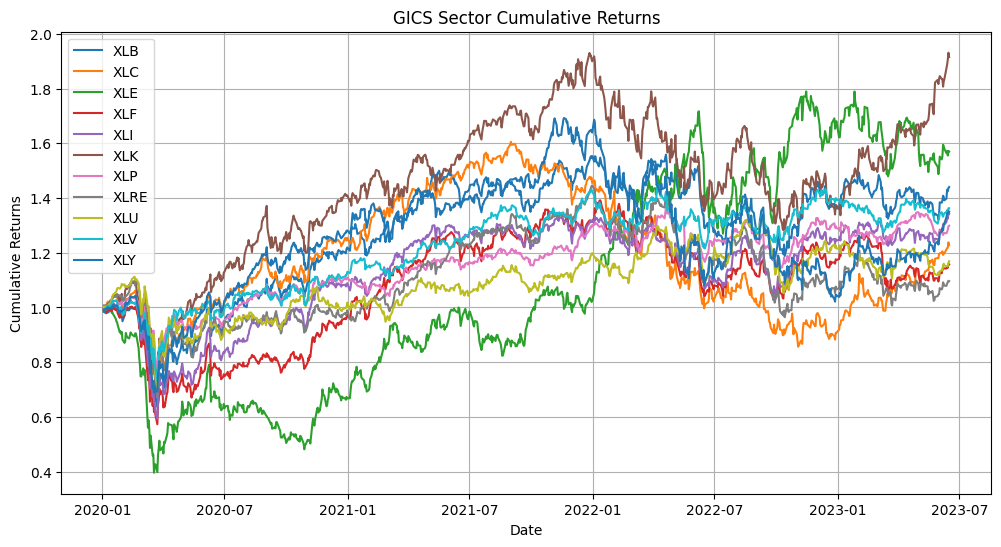

In [6]:
plt.figure(figsize=(12, 6))

for sector in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[sector], label=sector)

plt.title("GICS Sector Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Initialize a dictionary to store the returns
returns_dict = {}

# Initialize a list to store the forecasted dataframes
forecast_dfs = []

data_close = data['Adj Close']

data_close = data_close.reset_index(inplace=False)

# Iterate over each stock symbol
for symbol in gics_sectors:
    
    # Reset the index and keep only 'Date' and 'Close' columns
    stock_data = data_close[['Date', symbol]]
    stock_data.columns = ['ds', 'y']
    
    # Create and fit the Prophet model
    model = Prophet()
    model.fit(stock_data)

    # Generate future dates
    future_dates = model.make_future_dataframe(periods=365)

    # Make predictions
    forecast = model.predict(future_dates)

    # Extract the relevant columns from the forecast
    forecast_subset = forecast[['ds', 'yhat']]

    # Filter the forecast for next year's data
    next_year_forecast = forecast_subset[forecast_subset['ds'].dt.year == forecast_subset['ds'].dt.year.max()]

    # Calculate the percentage change in stock prices
    start_price = next_year_forecast.iloc[0]['yhat']
    end_price = next_year_forecast.iloc[-1]['yhat']
    returns = (end_price - start_price) / start_price * 100

    # Store the returns in the dictionary
    returns_dict[symbol] = returns

    # Store the forecast dataframe
    forecast_dfs.append(forecast_subset)


18:51:12 - cmdstanpy - INFO - Chain [1] start processing
18:51:13 - cmdstanpy - INFO - Chain [1] done processing
18:51:14 - cmdstanpy - INFO - Chain [1] start processing
18:51:14 - cmdstanpy - INFO - Chain [1] done processing
18:51:15 - cmdstanpy - INFO - Chain [1] start processing
18:51:15 - cmdstanpy - INFO - Chain [1] done processing
18:51:16 - cmdstanpy - INFO - Chain [1] start processing
18:51:16 - cmdstanpy - INFO - Chain [1] done processing
18:51:17 - cmdstanpy - INFO - Chain [1] start processing
18:51:18 - cmdstanpy - INFO - Chain [1] done processing
18:51:18 - cmdstanpy - INFO - Chain [1] start processing
18:51:19 - cmdstanpy - INFO - Chain [1] done processing
18:51:20 - cmdstanpy - INFO - Chain [1] start processing
18:51:20 - cmdstanpy - INFO - Chain [1] done processing
18:51:21 - cmdstanpy - INFO - Chain [1] start processing
18:51:21 - cmdstanpy - INFO - Chain [1] done processing
18:51:22 - cmdstanpy - INFO - Chain [1] start processing
18:51:22 - cmdstanpy - INFO - Chain [1]

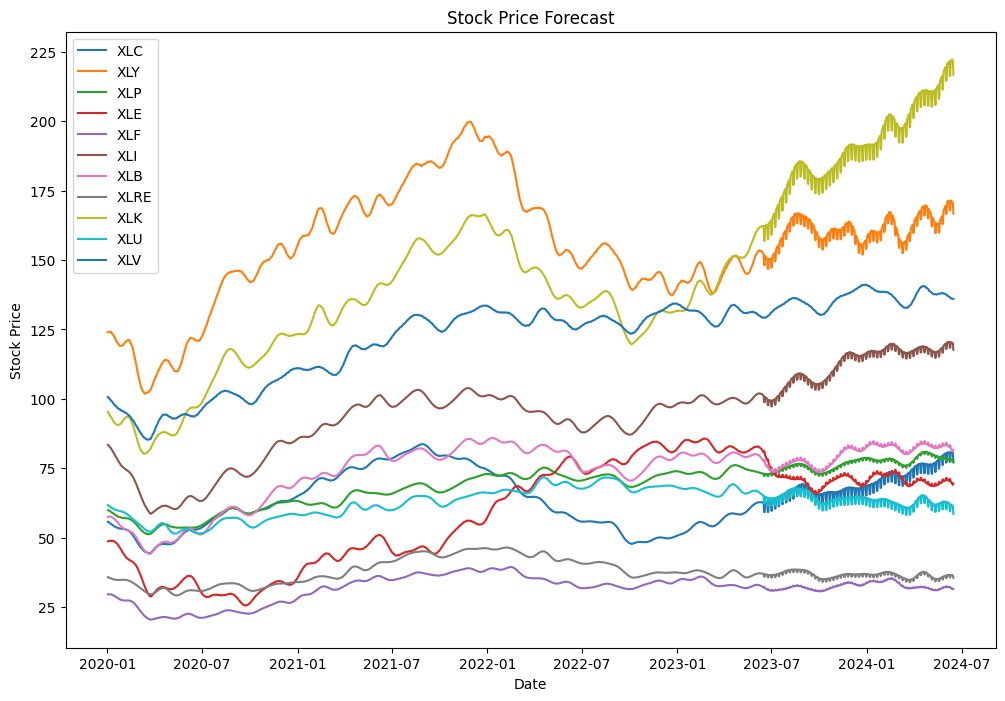

In [10]:
# Plot the forecasted stock prices for all stocks in a single figure
plt.figure(figsize=(12, 8))
for i, forecast_df in enumerate(forecast_dfs):
    symbol = gics_sectors[i]
    plt.plot(forecast_df['ds'], forecast_df['yhat'], label=symbol)

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Forecast')
plt.legend()
plt.show()

In [16]:
# Calculate growth percentages for each sector
growth_percentages = {}
for symbol in gics_sectors:
    sector_data = data['Adj Close'][symbol]
    growth_percentage = (sector_data[-1] - sector_data[0]) / sector_data[0] * 100
    growth_percentages[symbol] = growth_percentage

In [12]:
result = {key: growth_percentages.get(key, 0) - returns_dict.get(key, 0) for key in set(growth_percentages) | set(returns_dict)}

In [13]:
# diversity of stock using growth percentages

# Calculate the sum of all values in the dictionary
sum_values = sum(growth_percentages.values())

# Calculate the percentage for each value
percentages = {key:  round((value / sum_values) * 100,0) for key, value in growth_percentages.items()}

In [14]:
new_keys = ['Communication Services','Consumer Discretionary','Consumer Staples','Energy','Financials','Industrials','Materials','Real Estate', 'Information Technology' ,'Utilities', 'Health Care']

for i, old_key in enumerate(list(percentages.keys())):
    new_key = new_keys[i]
    percentages[new_key] = percentages.pop(old_key)


In [18]:
for symbol, growth_percentage in percentages.items():
    print(f"{symbol}: {growth_percentage:}%")

Communication Services: 6.0%
Consumer Discretionary: 9.0%
Consumer Staples: 8.0%
Energy: 15.0%
Financials: 4.0%
Industrials: 9.0%
Materials: 11.0%
Real Estate: 2.0%
Information Technology: 23.0%
Utilities: 4.0%
Health Care: 9.0%
